# Exploratary data analysis 
Hourly number of trips analysis 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 
from folium.plugins import HeatMap


In [2]:
# Load the Parquet file into a Pandas DataFrame
df = pd.read_parquet("../data/curated/tlc_data/first_cleaned.parquet/")


## Data processing

In [3]:
# Drop rows with any missing values
clean_df = df.dropna()

# Check the number of remaining rows
remaining_rows = clean_df.shape[0]
total_rows = df.shape[0]

print(f"Remaining rows after dropping missing values: {remaining_rows} out of {total_rows}")

# Print percentage of rows remaining
print(f"Percentage of rows remaining: {remaining_rows / total_rows * 100:.2f}%")

Remaining rows after dropping missing values: 38461 out of 48611
Percentage of rows remaining: 79.12%


In [4]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks in the output

# Get summary statistics for all columns, including non-numerical ones
summary_stats = clean_df.describe(include='all')

# Display the summary statistics
print(summary_stats)

                             datetime PUBorough pickup_date   pickup_hour  hourly_trip_count  Number of Events           CIG           WND          VIS           TMP           DEW           SLP
count                           38461     38461       38461  38461.000000       38461.000000      38461.000000  38461.000000  38461.000000  38461.00000  38461.000000  38461.000000  38461.000000
unique                            NaN         6         182           NaN                NaN               NaN           NaN           NaN          NaN           NaN           NaN           NaN
top                               NaN    Queens  2023-09-11           NaN                NaN               NaN           NaN           NaN          NaN           NaN           NaN           NaN
freq                              NaN     10175         459           NaN                NaN               NaN           NaN           NaN          NaN           NaN           NaN           NaN
mean    2023-09-28 00:54:42.50

In [5]:
# extract a month column from the pickup_datet column
clean_df['pickup_month'] = pd.to_datetime(clean_df['pickup_date']).dt.month

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_4482/3112833270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['pickup_month'] = pd.to_datetime(clean_df['pickup_date']).dt.month


In [6]:
# check what features are available
print(clean_df.columns)

Index(['datetime', 'PUBorough', 'pickup_date', 'pickup_hour',
       'hourly_trip_count', 'Number of Events', 'CIG', 'WND', 'VIS', 'TMP',
       'DEW', 'SLP', 'pickup_month'],
      dtype='object')


### Hourly demand

In [7]:
# Group by 'pickup_hour' and 'PUBorough' to get the sum of trips and average weather data
hourly_demand = clean_df.groupby(['pickup_hour', 'PUBorough']).agg({
    'hourly_trip_count': 'sum',
    'TMP': 'mean',
    'VIS': 'mean',
    'Number of Events': 'sum'
}).reset_index()

# Rename the columns to match the desired output
hourly_demand.rename(columns={
    'hourly_trip_count': 'total_hourly_trips',
    'TMP': 'avg_temperature',
    'VIS': 'avg_visibility',
    'Number of Events': 'total_events'
}, inplace=True)

# Round the average temperature and visibility to 1 decimal place
hourly_demand['avg_temperature'] = hourly_demand['avg_temperature'].round(1)
hourly_demand['avg_visibility'] = hourly_demand['avg_visibility'].round(1)

# Show the first 10 rows of the aggregated result
print(hourly_demand.head(5))

   pickup_hour  PUBorough  total_hourly_trips  avg_temperature  avg_visibility  total_events
0            0      Bronx                6681             18.2          1278.8           325
1            0   Brooklyn              120054             17.2          1275.2          9276
2            0        EWR                 141             19.6          1263.7             0
3            0  Manhattan            13342339             17.2          1275.6         79404
4            0     Queens             2031213             17.2          1269.7          5748


## Distribution Analysis 

In [8]:
# Step 1: Load the shapefile of NYC boroughs
gdf = gpd.read_file("../data/landing/external/geo_export_f16e615f-62c7-40bb-856c-2cccde28f16b.shp")

# Convert to GeoJSON
geojson_data = gdf.to_json()

# Check the first 5 rows of the GeoDataFrame
gdf.head(5)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.695, -74.18449 40.69509..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [9]:
# Total hourly trips by borough
agg_data = clean_df.groupby('PUBorough').agg({
    'hourly_trip_count': 'sum'
}).reset_index()

# Rename the columns to match the desired output
agg_data.rename(columns={'PUBorough': 'borough', 'hourly_trip_count': 'total_hourly_trips'}, inplace=True)

# Ensure the data is in the correct format by selecting only the relevant columns
agg_data = agg_data[['borough', 'total_hourly_trips']]

# Display the first 5 rows of the aggregated data
agg_data.head(610)


,borough,total_hourly_trips
0,Bronx,31848
1,Brooklyn,205997
2,EWR,358
3,Manhattan,27579303
4,Queens,3695828
5,Staten Island,361


### Hourly Trips by Borough

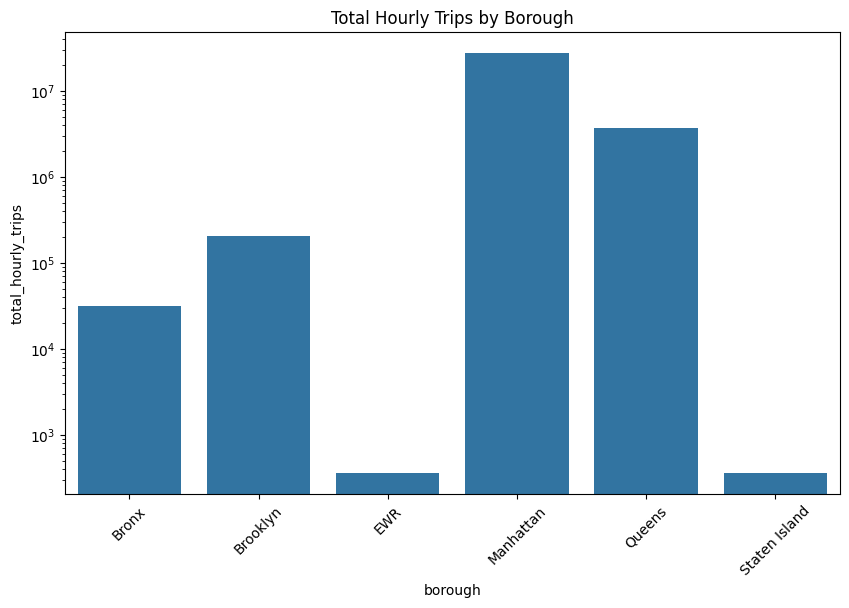

In [10]:
# Create a bar chart with a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn
sbs.barplot(x='borough', y='total_hourly_trips', data=agg_data, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Hourly Trips by Borough')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [11]:
# save the plot
fig.savefig("../plots/total_hourly_trips_by_borough.png")

## Event distribution by borough

In [12]:
# plot event distribution by borough
agg_data_events = clean_df.groupby('PUBorough').agg({
    'Number of Events': 'sum'
}).reset_index()

In [13]:
# Rename the columns to match the expected output
agg_data_events.rename(columns={'PUBorough': 'borough', 'Number of Events': 'total_events'}, inplace=True)

         borough  total_events
0          Bronx         20918
1       Brooklyn         46648
2            EWR             0
3      Manhattan        130198
4         Queens         38690
5  Staten Island           741


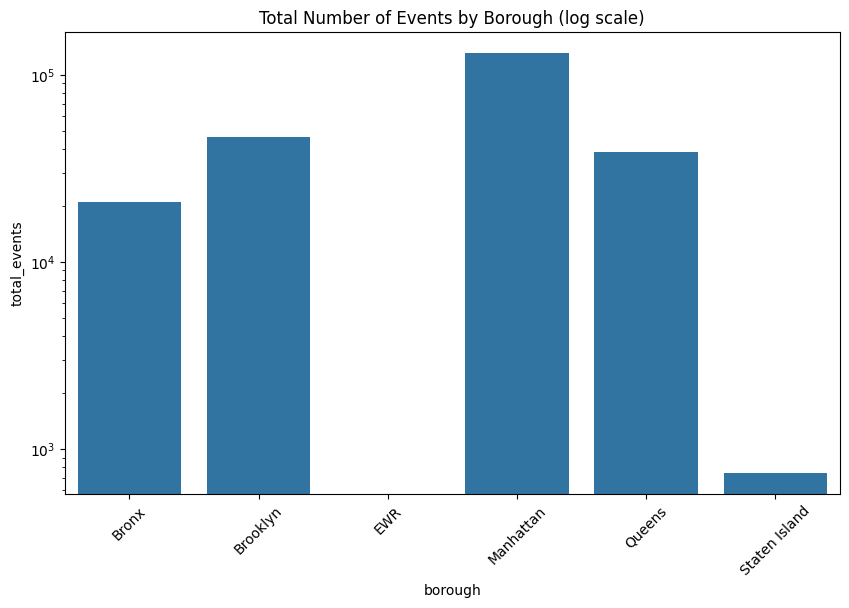

In [14]:
# Display the first 5 rows of the aggregated data
print(agg_data_events.head(6))
# Create a bar chart for the total number of events by borough
fig, ax = plt.subplots(figsize=(10, 6))
# Create the bar plot using Seaborn with log scale
sbs.barplot(x='borough', y='total_events', data=agg_data_events, ax=ax) 
# Set the y-axis to a logarithmic scale
ax.set_yscale('log')
# Set the title of the plot
ax.set_title('Total Number of Events by Borough (log scale)')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [15]:
# save the plot
fig.savefig("../plots/total_events_by_borough.png")

## Correlation Analysis 

In [16]:
# Calculate correlations for hourly trip count
temp_hourly_corr = clean_df['TMP'].corr(clean_df['hourly_trip_count'])
vis_hourly_corr = clean_df['VIS'].corr(clean_df['hourly_trip_count'])
events_hourly_corr = np.log1p(clean_df['Number of Events']).corr(clean_df['hourly_trip_count'])

# Create a DataFrame to hold the correlation results
correlation_matrix = pd.DataFrame({
    'Correlation': ['temp_hourly_corr', 'vis_hourly_corr', 'events_hourly_corr'
                ],
    'Value': [temp_hourly_corr, vis_hourly_corr, events_hourly_corr, 
              ]
})

# Display the correlation matrix
print(correlation_matrix)


          Correlation     Value
0    temp_hourly_corr -0.029598
1     vis_hourly_corr  0.023891
2  events_hourly_corr  0.419766


## Bivariate Analysis

### Number of events vs dates

In [39]:
# print features
print(clean_df.columns)

Index(['datetime', 'PUBorough', 'pickup_date', 'pickup_hour',
       'hourly_trip_count', 'Number of Events', 'CIG', 'WND', 'VIS', 'TMP',
       'DEW', 'SLP', 'pickup_month'],
      dtype='object')


### Events over dates

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_1330/3444997128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Event Date'] = pd.to_datetime(clean_df['pickup_date']).dt.date


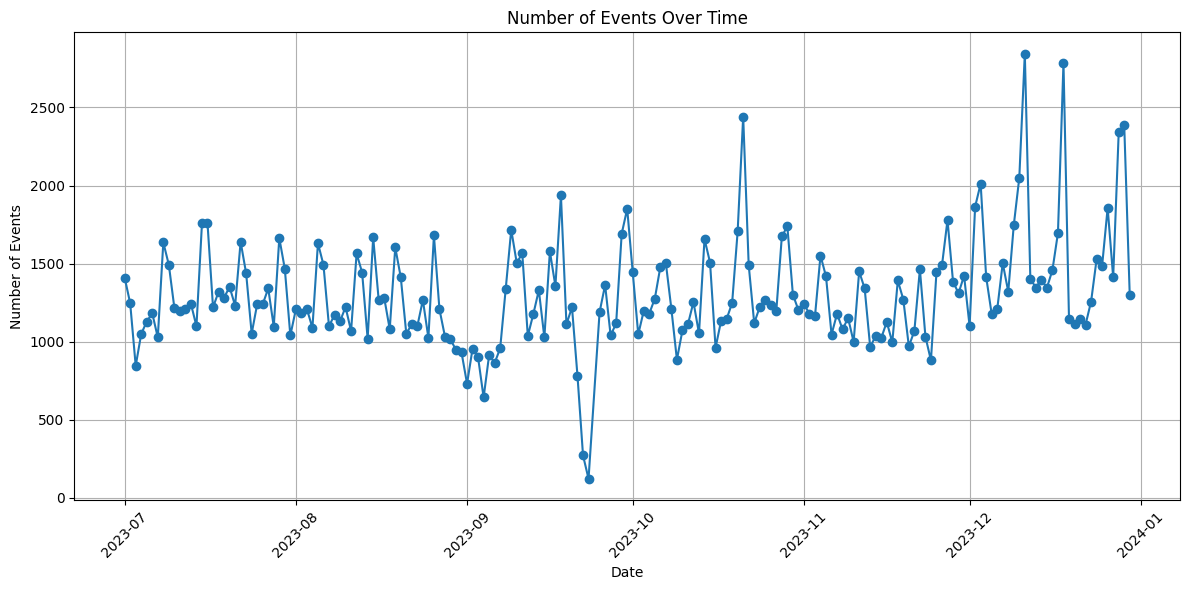

In [51]:
# Convert 'pickup_date' to datetime and extract just the date part if not already done
clean_df['Event Date'] = pd.to_datetime(clean_df['pickup_date']).dt.date

# Group by 'Event Date' and count the number of events
events_per_date_df = clean_df.groupby('Event Date').agg({'Number of Events': 'sum'}).reset_index()

# Plot the date vs number of events
plt.figure(figsize=(12, 6))
plt.plot(events_per_date_df['Event Date'], events_per_date_df['Number of Events'], marker='o', linestyle='-')
plt.title('Number of Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('../plots/number_of_events_over_time.png')
# Show the plot
plt.show()


<Figure size 640x480 with 0 Axes>

### Events for each day of week

In [42]:
# plot the number of events per day of the week
# Convert the 'Event Date' to a datetime object
clean_df['Event Date'] = pd.to_datetime(clean_df['Event Date'])

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_1330/2317940689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Event Date'] = pd.to_datetime(clean_df['Event Date'])


In [43]:
# Extract the day of the week from the 'Event Date'
clean_df['Day of Week'] = clean_df['Event Date'].dt.day_name()

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_1330/2664269605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Day of Week'] = clean_df['Event Date'].dt.day_name()


In [44]:
# Group by 'Day of Week' and count the number of events
events_per_day_df = clean_df.groupby(['Day of Week', "pickup_month"]).agg({'Number of Events': 'sum'}).reset_index()

In [45]:
# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_1330/4170963009.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sbs.lineplot(x='Day of Week', y='Number of Events', data=events_per_day_df, hue='pickup_month', palette=palette, sort=True)


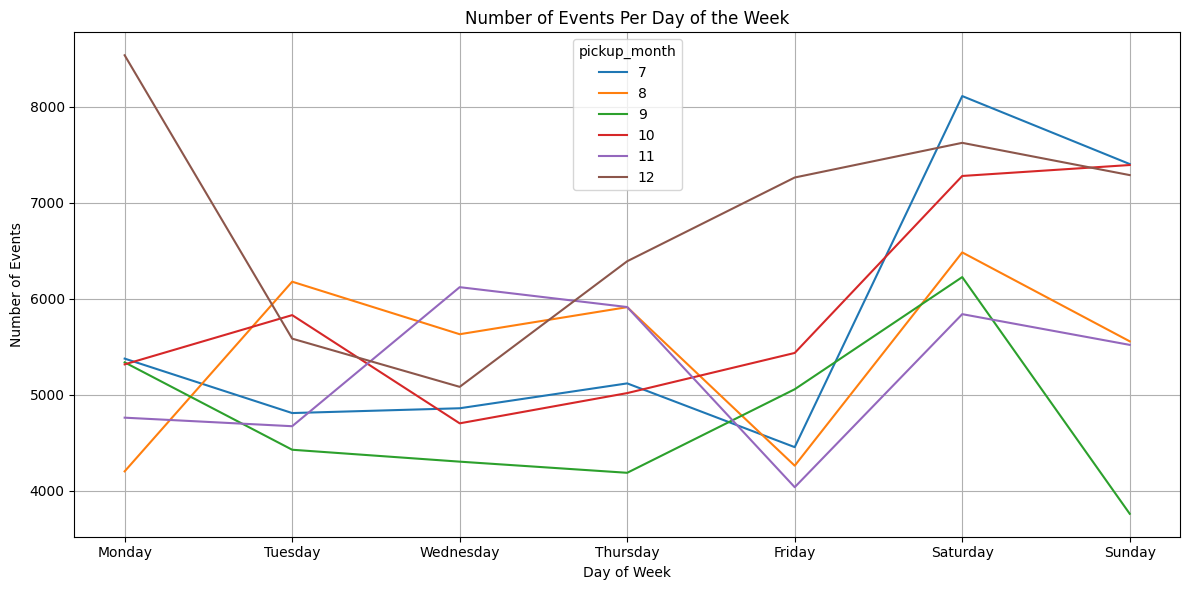

In [50]:
# Define a color palette
palette = sbs.color_palette("tab10")  # Or use any other palette like 'husl', 'coolwarm', etc.

# Plot the number of events per day of the week
plt.figure(figsize=(12, 6))
sbs.lineplot(x='Day of Week', y='Number of Events', data=events_per_day_df, hue='pickup_month', palette=palette, sort=True)
plt.title('Number of Events Per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events')
plt.grid(True)
plt.tight_layout()
plt.savefig('../plots/number_of_events_per_day_of_week.png')
plt.show()
